In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [13]:
#Read in data
#Do same data preprocessingas kaggle guy
#Show histplot of price
#Multiple regression stan model

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [25]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle):

In [26]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
# Need to scale price for stan
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

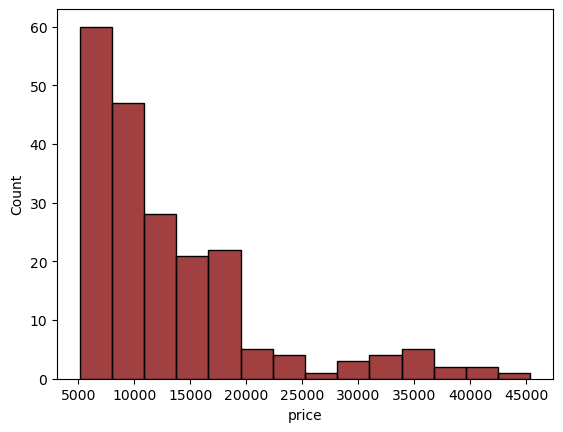

In [27]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

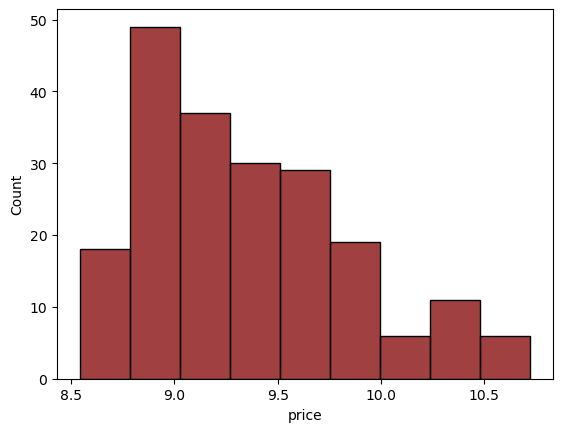

In [30]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

<Axes: xlabel='peakrpm', ylabel='Count'>

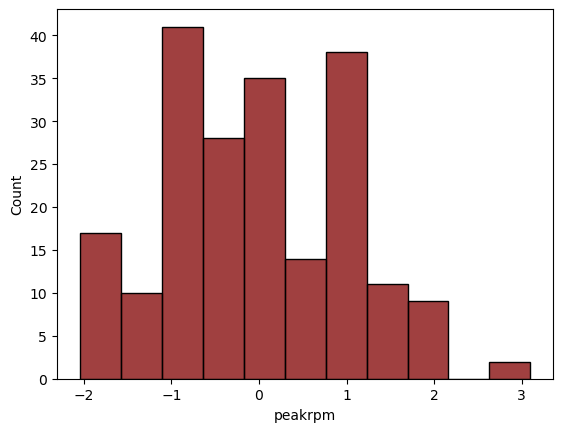

In [80]:
sns.histplot(data.peakrpm, color='maroon')

In [72]:
# Split data into train and test set
X = np.array(data.drop(['price', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'log_enginesize'], axis=1))
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Split data into train and test set
X = np.column_stack((data['highwaympg'], data['citympg'], data['enginesize']))
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [118]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(0, 10);
    alpha ~ normal(9.2, 2);
    beta ~ normal(9.2, 2);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [119]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: 19.7s, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


In [120]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,118.203652,0.958618,0.181684,4.0,15.0,0.0,-116.783298,0.267737,9.352806,-0.166415,...,9.210802,9.076273,10.185591,8.593357,10.395871,9.505626,9.493834,8.359943,9.439440,8.678352
1,119.445650,0.971934,0.161214,5.0,31.0,0.0,-118.400255,0.243433,9.351012,-0.133997,...,8.889887,8.931314,9.885272,9.003890,10.325231,9.025832,9.495859,8.706321,9.740086,9.437315
2,121.794328,0.978888,0.169423,4.0,15.0,0.0,-119.532935,0.230515,9.367603,-0.008205,...,8.940699,9.448154,9.789407,9.245890,9.952319,9.875187,9.479566,8.728671,9.762214,9.418156
3,120.391029,0.886506,0.171168,5.0,31.0,0.0,-117.880533,0.230254,9.361928,0.102596,...,8.708759,8.774939,10.084238,9.371835,9.834414,9.120769,9.291008,8.378744,9.935308,9.055712
4,117.996273,0.980379,0.181684,4.0,31.0,0.0,-116.556335,0.262265,9.349327,-0.200183,...,8.839437,8.676783,10.240888,9.420393,10.188201,9.214268,9.263176,8.953803,9.916564,9.134374


In [121]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.240,0.014,0.215,0.265,0.000,0.000,5605.0,4969.0,1.0
alpha,9.353,0.019,9.318,9.387,0.000,0.000,6184.0,4433.0,1.0
beta[0],-0.008,0.078,-0.152,0.140,0.001,0.001,3924.0,4450.0,1.0
beta[1],-0.225,0.076,-0.368,-0.084,0.001,0.001,3989.0,4624.0,1.0
beta[2],0.271,0.026,0.223,0.320,0.000,0.000,6167.0,5069.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.271,0.239,8.817,9.704,0.003,0.002,8281.0,7634.0,1.0
pred_y[37],9.277,0.248,8.830,9.759,0.003,0.002,7536.0,7510.0,1.0
pred_y[38],8.657,0.243,8.188,9.103,0.003,0.002,7973.0,7614.0,1.0
pred_y[39],9.765,0.244,9.315,10.242,0.003,0.002,7703.0,7079.0,1.0


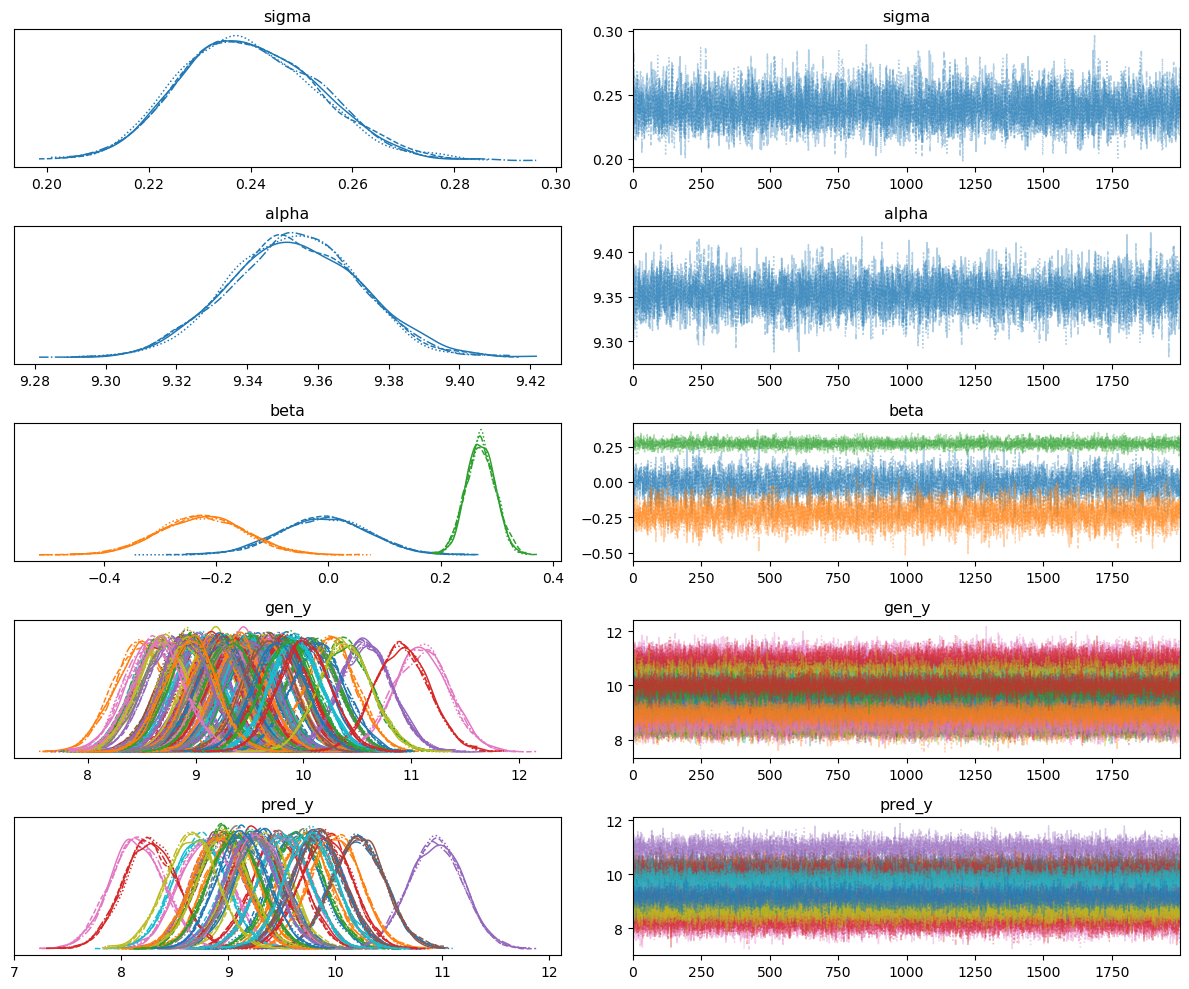

In [122]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

In [130]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.23507122865634075
R2-Score: 0.7770889601025623


In [131]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.2388333795143802
R2-Score: 0.7897676423113056
